
--- This is a regression problem ---

1. Loading dataset from file...

2. Calculating gram matrices. This could take a while...

 --- mean average path kernel matrix of size 183 built in 21.83512854576111 seconds ---

gram matrix with parameters {} is: 
[[0.55555556 0.22222222 0.         ... 0.         0.         0.        ]
 [0.22222222 0.27777778 0.         ... 0.         0.         0.        ]
 [0.         0.         0.55555556 ... 0.03030303 0.03030303 0.03030303]
 ...
 [0.         0.         0.03030303 ... 0.08297521 0.05553719 0.05256198]
 [0.         0.         0.03030303 ... 0.05553719 0.07239669 0.0538843 ]
 [0.         0.         0.03030303 ... 0.05256198 0.0538843  0.07438017]]


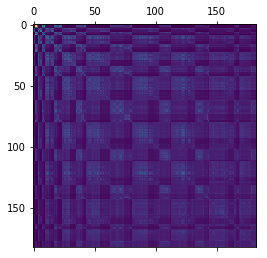


3. Fitting and predicting using nested cross validation. This could really take a while...
calculate performance:   0%|          | 1/1200 [00:00<02:00,  9.98it/s]

/home/ljia/.local/lib/python3.5/site-packages/sklearn/linear_model/ridge.py:154: UserWarning: Singular matrix in solving dual problem. Using least-squares solution instead.
  warnings.warn("Singular matrix in solving dual problem. Using "


                                                                          
4. Getting final performances...

best_params_out:  [{}]
best_params_in:  [{'alpha': 0.0025719138090593446}]
best_val_perf:  23.66357723619167
best_val_std:  1.7375991881363788
final_performance:  25.04174263900284
final_confidence:  9.596718064653482
train_performance:  11.194641025303468
train_std:  0.7327157793544619
time to calculate gram matrix:  21.83512854576111 s

params                 train_perf    valid_perf     test_perf         gram_matrix_time
---------------------  ------------  -------------  --------------  ------------------
{'alpha': '1.00e-04'}  19.23±17.16   144.93±259.55  78.37±110.59                 21.84
{'alpha': '1.34e-04'}  24.29±41.62   124.75±185.82  264.04±1154.46               21.84
{'alpha': '1.80e-04'}  17.57±13.69   90.89±97.20    65.45±85.08                  21.84
{'alpha': '2.42e-04'}  16.45±11.32   70.08±62.49    54.85±55.03                  21.84
{'alpha': '3.26e-04'}  15.95

In [1]:
%load_ext line_profiler
%matplotlib inline
import numpy as np
import sys
sys.path.insert(0, "../")
from pygraph.utils.model_selection_precomputed import model_selection_for_precomputed_kernel
from pygraph.kernels.pathKernel import pathkernel

datafile = '../../../../datasets/acyclic/Acyclic/dataset_bps.ds'
estimator = pathkernel
param_grid_precomputed = {}
param_grid = {'alpha': np.logspace(-4, 1, num = 40, base = 10)}

model_selection_for_precomputed_kernel(datafile, estimator, param_grid_precomputed, param_grid, 
                                       'regression', NUM_TRIALS=30)

In [2]:
%load_ext line_profiler

import sys
sys.path.insert(0, "../")
from pygraph.utils.utils import kernel_train_test
from pygraph.kernels.pathKernel import pathkernel, _pathkernel_do

datafile = '../../../../datasets/acyclic/Acyclic/dataset_bps.ds'
kernel_file_path = 'kernelmatrices_path_acyclic/'

kernel_para = dict(node_label = 'atom', edge_label = 'bond_type')

kernel_train_test(datafile, kernel_file_path, pathkernel, kernel_para, normalize = False)

# %lprun -f _pathkernel_do \
#     kernel_train_test(datafile, kernel_file_path, pathkernel, kernel_para, normalize = False)

The line_profiler extension is already loaded. To reload it, use:
  %reload_ext line_profiler

 --- This is a regression problem ---


 Loading dataset from file...

 Calculating kernel matrix, this could take a while...

 --- mean average path kernel matrix of size 185 built in 29.430902242660522 seconds ---
[[ 0.55555556  0.22222222  0.         ...,  0.          0.          0.        ]
 [ 0.22222222  0.27777778  0.         ...,  0.          0.          0.        ]
 [ 0.          0.          0.55555556 ...,  0.03030303  0.03030303
   0.03030303]
 ..., 
 [ 0.          0.          0.03030303 ...,  0.08297521  0.05553719
   0.05256198]
 [ 0.          0.          0.03030303 ...,  0.05553719  0.07239669
   0.0538843 ]
 [ 0.          0.          0.03030303 ...,  0.05256198  0.0538843
   0.07438017]]

 Saving kernel matrix to file...

 Mean performance on train set: 3.619948
With standard deviation: 0.512351

 Mean performance on test set: 18.418852
With standard deviation: 10.781119


  rms

In [ ]:
# results

# with y normalization
  RMSE_test    std_test    RMSE_train    std_train    k_time
-----------  ----------  ------------  -----------  --------
    14.0015     6.93602       3.76191     0.702594   37.5759

# without y normalization
  RMSE_test    std_test    RMSE_train    std_train    k_time
-----------  ----------  ------------  -----------  --------
    18.4189     10.7811       3.61995     0.512351   29.4309

In [1]:
# Author: Elisabetta Ghisu

"""
- This script take as input a kernel matrix
and returns the classification or regression performance
- The kernel matrix can be calculated using any of the graph kernels approaches
- The criteria used for prediction are SVM for classification and kernel Ridge regression for regression
- For predition we divide the data in training, validation and test. For each split, we first train on the train data, 
then evaluate the performance on the validation. We choose the optimal parameters for the validation set and finally
provide the corresponding performance on the test set. If more than one split is performed, the final results 
correspond to the average of the performances on the test sets. 

@references
    https://github.com/eghisu/GraphKernels/blob/master/GraphKernelsCollection/python_scripts/compute_perf_gk.py
"""

print(__doc__)

import sys
import os
import pathlib
from collections import OrderedDict
sys.path.insert(0, "../")
from tabulate import tabulate

import numpy as np
import matplotlib.pyplot as plt

from pygraph.kernels.pathKernel import pathkernel
from pygraph.utils.graphfiles import loadDataset
from pygraph.utils.utils import split_train_test

train_means_list = []
train_stds_list = []
test_means_list = []
test_stds_list = []
kernel_time_list = []

print('\n Loading dataset from file...')
dataset, y = loadDataset("../../../../datasets/acyclic/Acyclic/dataset_bps.ds")
y = np.array(y)
print(y)

# setup the parameters
model_type = 'regression' # Regression or classification problem
print('\n --- This is a %s problem ---' % model_type)

trials = 100 # Trials for hyperparameters random search
splits = 10 # Number of splits of the data
alpha_grid = np.logspace(-10, 10, num = trials, base = 10) # corresponds to (2*C)^-1 in other linear models such as LogisticRegression
C_grid = np.logspace(-10, 10, num = trials, base = 10)

# set the output path
kernel_file_path = 'kernelmatrices_path_acyclic/'
if not os.path.exists(kernel_file_path):
    os.makedirs(kernel_file_path)

"""
-  Here starts the main program
-  First we permute the data, then for each split we evaluate corresponding performances
-  In the end, the performances are averaged over the test sets
"""

# save kernel matrices to files / read kernel matrices from files
kernel_file = kernel_file_path + 'km.ds'
path = pathlib.Path(kernel_file)
# get train set kernel matrix
if path.is_file():
    print('\n Loading the kernel matrix from file...')
    Kmatrix = np.loadtxt(kernel_file)
    print(Kmatrix)
else:
    print('\n Calculating kernel matrix, this could take a while...')
    Kmatrix, run_time = pathkernel(dataset, node_label = 'atom', edge_label = 'bond_type')
    kernel_time_list.append(run_time)
    print(Kmatrix)
    print('\n Saving kernel matrix to file...')
#     np.savetxt(kernel_file, Kmatrix)
    
train_mean, train_std, test_mean, test_std = \
    split_train_test(Kmatrix, y, alpha_grid, C_grid, splits, trials, model_type, normalize = True)
    
train_means_list.append(train_mean)
train_stds_list.append(train_std)
test_means_list.append(test_mean)
test_stds_list.append(test_std)
        
print('\n') 
table_dict = {'RMSE_test': test_means_list, 'std_test': test_stds_list, \
    'RMSE_train': train_means_list, 'std_train': train_stds_list, 'k_time': kernel_time_list}
keyorder = ['RMSE_test', 'std_test', 'RMSE_train', 'std_train', 'k_time']
print(tabulate(OrderedDict(sorted(table_dict.items(), key = lambda i:keyorder.index(i[0]))), headers='keys'))


- This script take as input a kernel matrix
and returns the classification or regression performance
- The kernel matrix can be calculated using any of the graph kernels approaches
- The criteria used for prediction are SVM for classification and kernel Ridge regression for regression
- For predition we divide the data in training, validation and test. For each split, we first train on the train data, 
then evaluate the performance on the validation. We choose the optimal parameters for the validation set and finally
provide the corresponding performance on the test set. If more than one split is performed, the final results 
correspond to the average of the performances on the test sets. 

@references
    https://github.com/eghisu/GraphKernels/blob/master/GraphKernelsCollection/python_scripts/compute_perf_gk.py



IndentationError: unindent does not match any outer indentation level (utils.py, line 106)

In [1]:
import sys
import networkx as nx
sys.path.insert(0, "../")
from pygraph.utils.graphfiles import loadDataset
from pygraph.kernels.deltaKernel import deltaKernel

dataset, y = loadDataset("../../../../datasets/acyclic/Acyclic/dataset_bps.ds")
G1 = dataset[12]
G2 = dataset[55]
sp1 = []
num_nodes = G1.number_of_nodes()
for node1 in range(num_nodes):
    for node2 in range(node1 + 1, num_nodes):
            sp1.append(nx.shortest_path(G1, node1, node2, weight = 'cost'))
print(sp1)
print(len(sp1))
sp2 = []
num_nodes = G2.number_of_nodes()
for node1 in range(num_nodes):
    for node2 in range(node1 + 1, num_nodes):
            sp2.append(nx.shortest_path(G2, node1, node2, weight = 'cost'))
print(sp2)
print(len(sp2))

kernel = 0
for path1 in sp1:
    for path2 in sp2:
        if len(path1) == len(path2):
            kernel_path = deltaKernel(G1.node[path1[0]]['label'] == G2.node[path2[0]]['label'])
            print(kernel_path)
            if kernel_path:
                print('yes')
                for i in range(1, len(path1)):
                    kernel_path *= deltaKernel(G1[path1[i - 1]][path1[i]]['label'] == G2[path2[i - 1]][path2[i]]['label']) * deltaKernel(G1.node[path1[i]]['label'] == G2.node[path2[i]]['label'])
                kernel += kernel_path
        
kernel = kernel / (len(sp1) * len(sp2))

print(kernel)

ImportError: cannot import name 'deltaKernel'

In [30]:
# Author: Elisabetta Ghisu

"""
- This script take as input a kernel matrix
and returns the classification or regression performance
- The kernel matrix can be calculated using any of the graph kernels approaches
- The criteria used for prediction are SVM for classification and kernel Ridge regression for regression
- For predition we divide the data in training, validation and test. For each split, we first train on the train data, 
then evaluate the performance on the validation. We choose the optimal parameters for the validation set and finally
provide the corresponding performance on the test set. If more than one split is performed, the final results 
correspond to the average of the performances on the test sets. 

@references
    https://github.com/eghisu/GraphKernels/blob/master/GraphKernelsCollection/python_scripts/compute_perf_gk.py
"""

print(__doc__)

import sys
import pathlib
import os
sys.path.insert(0, "../")
from tabulate import tabulate

import random
import numpy as np
import matplotlib.pyplot as plt

from sklearn.kernel_ridge import KernelRidge # 0.17
from sklearn.metrics import accuracy_score, mean_squared_error
from sklearn import svm

from pygraph.kernels.pathKernel import pathKernel
from pygraph.utils.graphfiles import loadDataset

# print('\n Loading dataset from file...')
# dataset, y = loadDataset("/home/ljia/Documents/research-repo/datasets/acyclic/Acyclic/dataset_bps.ds")
# y = np.array(y)
# print(y)

# kernel_file_path = 'marginalizedkernelmatrix.ds'
# path = pathlib.Path(kernel_file_path)
# if path.is_file():
#     print('\n Loading the matrix from file...')
#     Kmatrix = np.loadtxt(kernel_file_path)
#     print(Kmatrix)
# else:
#     print('\n Calculating kernel matrix, this could take a while...')
#     Kmatrix = marginalizeKernel(dataset)
#     print(Kmatrix)
#     print('Saving kernel matrix to file...')
#     np.savetxt(kernel_file_path, Kmatrix)

# setup the parameters
model_type = 'regression' # Regression or classification problem
print('\n --- This is a %s problem ---' % model_type)

# datasize = len(dataset)
trials = 100 # Trials for hyperparameters random search
splits = 100 # Number of splits of the data
alpha_grid = np.linspace(0.01, 100, num = trials) # corresponds to (2*C)^-1 in other linear models such as LogisticRegression
# C_grid = np.linspace(0.0001, 10, num = trials)
random.seed(20) # Set the seed for uniform parameter distribution
data_dir = '/home/ljia/Documents/research-repo/datasets/acyclic/Acyclic/'

# set the output path
kernel_file_path = 'kernelmatrices_marginalized_acyclic/'
if not os.path.exists(kernel_file_path):
    os.makedirs(kernel_file_path)


"""
-  Here starts the main program
-  First we permute the data, then for each split we evaluate corresponding performances
-  In the end, the performances are averaged over the test sets
"""

# Initialize the performance of the best parameter trial on validation with the corresponding performance on test
val_split = []
test_split = []

p_quit = 0.5

# for each split of the data
for j in range(10):
    dataset_train, y_train = loadDataset(data_dir + 'trainset_' + str(j) + '.ds')
    dataset_test, y_test = loadDataset(data_dir + 'testset_' + str(j) + '.ds')
    
    # Normalization step (for real valued targets only)
    if model_type == 'regression':
        print('\n Normalizing output y...')
        y_train_mean = np.mean(y_train)
        y_train_std = np.std(y_train)
        y_train = (y_train - y_train_mean) / float(y_train_std)
#         print(y)
    
    # save kernel matrices to files / read kernel matrices from files
    kernel_file_train = kernel_file_path + 'train' + str(j) + '_pquit_' + str(p_quit)
    kernel_file_test = kernel_file_path + 'test' + str(j) + '_pquit_' + str(p_quit)
    path_train = pathlib.Path(kernel_file_train)
    path_test = pathlib.Path(kernel_file_test)
    # get train set kernel matrix
    if path_train.is_file():
        print('\n Loading the train set kernel matrix from file...')
        Kmatrix_train = np.loadtxt(kernel_file_train)
        print(Kmatrix_train)
    else:
        print('\n Calculating train set kernel matrix, this could take a while...')
        Kmatrix_train = marginalizedkernel(dataset_train, p_quit, 20)
        print(Kmatrix_train)
        print('\n Saving train set kernel matrix to file...')
        np.savetxt(kernel_file_train, Kmatrix_train)
    # get test set kernel matrix
    if path_test.is_file():
        print('\n Loading the test set kernel matrix from file...')
        Kmatrix_test = np.loadtxt(kernel_file_test)
        print(Kmatrix_test)
    else:
        print('\n Calculating test set kernel matrix, this could take a while...')
        Kmatrix_test = marginalizedkernel(dataset_test, p_quit, 20)
        print(Kmatrix_test)
        print('\n Saving test set kernel matrix to file...')
        np.savetxt(kernel_file_test, Kmatrix_test)

    # For each parameter trial
    for i in range(trials):
        # For regression use the Kernel Ridge method
        if model_type == 'regression':
    #             print('\n Starting experiment for trial %d and parameter alpha = %3f\n ' % (i, alpha_grid[i]))

            # Fit the kernel ridge model
            KR = KernelRidge(kernel = 'precomputed', alpha = alpha_grid[i])
            KR.fit(Kmatrix_train, y_train)

            # predict on the test set
            y_pred_test = KR.predict(Kmatrix_test)
    #             print(y_pred)

            # adjust prediction: needed because the training targets have been normalized
            y_pred_test = y_pred_test * float(y_train_std) + y_train_mean
    #             print(y_pred_test)

            # root mean squared error in test 
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
            perf_all_test.append(rmse_test)

    #             print('The performance on the validation set is: %3f' % rmse)
    #             print('The performance on the test set is: %3f' % rmse_test)

    # --- FIND THE OPTIMAL PARAMETERS --- #
    # For regression: minimise the mean squared error
    if model_type == 'regression':

        # get optimal parameter on test (argmin mean squared error)
        min_idx = np.argmin(perf_all_test)
        alpha_opt = alpha_grid[min_idx]

        # corresponding performance on test for the same parameter
        perf_test_opt = perf_all_test[min_idx]

        print('The best performance is for trial %d with parameter alpha = %3f' % (min_idx, alpha_opt))
        print('The corresponding performance on test set is: %3f' % perf_test_opt)
        
        
        

# For each split of the data
for j in range(10, 10 + splits):
    print('Starting split %d...' % j)

    # Set the random set for data permutation
    random_state = int(j)
    np.random.seed(random_state)
    idx_perm = np.random.permutation(datasize)
#     print(idx_perm)
    
    # Permute the data
    y_perm = y[idx_perm] # targets permutation
#     print(y_perm)
    Kmatrix_perm = Kmatrix[:, idx_perm] # inputs permutation
#     print(Kmatrix_perm)
    Kmatrix_perm = Kmatrix_perm[idx_perm, :] # inputs permutation
    
    # Set the training, validation and test
    # Note: the percentage can be set up by the user
    num_train_val = int((datasize * 90) / 100)         # 90% (of entire dataset) for training and validation
    num_test = datasize - num_train_val              # 10% (of entire dataset) for test
    num_train = int((num_train_val * 90) / 100) # 90% (of train + val) for training
    num_val = num_train_val - num_train # 10% (of train + val) for validation
    
    # Split the kernel matrix
    Kmatrix_train = Kmatrix_perm[0:num_train, 0:num_train]
    Kmatrix_val = Kmatrix_perm[num_train:(num_train + num_val), 0:num_train]
    Kmatrix_test = Kmatrix_perm[(num_train + num_val):datasize, 0:num_train]

    # Split the targets
    y_train = y_perm[0:num_train]

    # Normalization step (for real valued targets only)
    print('\n Normalizing output y...')
    if model_type == 'regression':
        y_train_mean = np.mean(y_train)
        y_train_std = np.std(y_train)
        y_train = (y_train - y_train_mean) / float(y_train_std)
#         print(y)
        
    y_val = y_perm[num_train:(num_train + num_val)]
    y_test = y_perm[(num_train + num_val):datasize]
    
    # Record the performance for each parameter trial respectively on validation and test set
    perf_all_val = []
    perf_all_test = []
    
    


- This script take as input a kernel matrix
and returns the classification or regression performance
- The kernel matrix can be calculated using any of the graph kernels approaches
- The criteria used for prediction are SVM for classification and kernel Ridge regression for regression
- For predition we divide the data in training, validation and test. For each split, we first train on the train data, 
then evaluate the performance on the validation. We choose the optimal parameters for the validation set and finally
provide the corresponding performance on the test set. If more than one split is performed, the final results 
correspond to the average of the performances on the test sets. 

@references
    https://github.com/eghisu/GraphKernels/blob/master/GraphKernelsCollection/python_scripts/compute_perf_gk.py


 --- This is a regression problem ---

 Normalizing output y...

 Loading the train set kernel matrix from file...
[[ 0.15254237  0.08333333  0.0625     ...,  0.11363636  0.

ValueError: Precomputed metric requires shape (n_queries, n_indexed). Got (19, 19) for 164 indexed.